# トレーナとエクステンション

[前章](https://tutorials.chainer.org/ja/src/15_Advanced_Usage_of_Chainer_ja.html)までは、訓練ループを Python の `while` 文を使って記述してきました。
訓練ループは、以下のような定型的な処理を繰り返し行うものでした。

**訓練ループで行われること**

1. イテレータがデータセットからデータを取り出し、ミニバッチを作成する
2. ミニバッチをネットワークに入力し、順伝播の計算を行う
3. ネットワークの出力と目標値を使って目的関数の値（損失）を計算する
4. 逆伝播によって各パラメータについての目的関数の勾配を計算する
5. 求まった勾配を使ってパラメータを更新する

このような定型的な処理を段階ごとに別々のオブジェクトにまとめ、さらにそれらのオブジェクトをまとめたものが**トレーナ (trainer)** です。

トレーナには**エクステンション (extension)** が用意されており、訓練曲線の可視化、訓練の途中状態やログの保存など、訓練ループ中に付加的な処理を追加することが容易になっています。

## トレーナの使用方法

### トレーナの概要

下図はトレーナを構成するオブジェクトの関係図です。 

![トレーナに関連するオブジェクト間の関係図](images/14/14_01.png)

それぞれの役割は以下のようになっています。  

| オブジェクト | 役割 |
|:-------------|:-----|
| **データセット (dataset)** | 訓練や検証に使用するためのデータの集合です。 |
| **イテレータ (iterator)** | データセットの一部をミニバッチとして切り出し、訓練中繰り返しデータセット内のデータを利用しやすくする機能を持ちます。 |
| **ネットワーク** (network) | 訓練を行いたいネットワークです。パラメータを保持し、ミニバッチを入力として損失を計算します。 |
| **オプティマイザ (optimizer)** | 選択された最適化の手法を用いて、ネットワークのパラメータの更新を行います。 |
| **アップデータ (updater)** | イテレータ・オプティマイザを統括し、順伝播・損失・逆伝播の計算、そしてパラメータの更新（オプティマイザの呼び出し）という、訓練ループ内の定型的な処理を実行します。 |
| **トレーナ (trainer)** | アップデータを受け取り、訓練全体の管理を行います。イテレータを用いてミニバッチを繰り返し作成し、オプティマイザを使ってネットワークのパラメータを更新します。訓練の終了タイミングの決定や、設定されたエクステンションの呼び出しも担います。 |
| **エクステンション (extension)** | トレーナに設定することができる付加的な機能です。エクステンションは複数設定することができます。よく利用されるエクステンションには、訓練の途中結果の保存や、検証用データセットによる訓練途中での性能の検証、訓練進捗の可視化などがあります。 |

次節より、トレーナを構成する各オブジェクトを順番に準備していきます。

まず、本章で利用するパッケージを予めいくつかインポートしておきます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import chainer
import chainer.links as L
import chainer.functions as F

### データセットの準備

ここでは scikit-learn の標準機能で用意されているデータセットのうち、[Chainer の基礎](https://tutorials.chainer.org/ja/src/14_Basics_of_Chainer_ja.html)の章でも利用した Iris というデータセットを使用します。これは、アヤメ科の植物のうち 3 種（Setosa、Versicolour、Virginica）のいずれかであるサンプル 150 個について、

- 花弁の長さ
- 花弁の幅
- がく片（[注釈1](#note1)）の長さ
- がく片の幅

の 4 つを測って集めたものです。
ここでは、各サンプルを見てそれが 3 種類の植物のうちどれに属するのかを予測します。

まず、[Step 1 : データセットの準備（応用編）](https://tutorials.chainer.org/ja/src/15_Advanced_Usage_of_Chainer_ja.html#Step-1-:-データセットの準備（応用編）)と同様に、scikit-learn の機能を使ってデータセットを読み込み、これを使って Chainer の `TupleDataset` クラスを利用してデータセットオブジェクトを作成します。

In [2]:
from sklearn.datasets import load_iris

# Iris データセットの読み込み
dataset = load_iris()

# 入力値と目標値を別々の変数へ格納
x = dataset.data
t = dataset.target

# Chainer がデフォルトで用いる float32 型へ変換
x = np.array(x, np.float32)
t = np.array(t, np.int32)

In [3]:
from chainer.datasets import TupleDataset

# 入力値と目標値を引数に与え、`TupleDataset` オブジェクトを作成
dataset = TupleDataset(x, t)

ここで、データセット全体を 7 : 1 : 2 の比率で分割し、それぞれを訓練用、検証用、テスト用のデータセットとします。

In [4]:
from chainer.datasets import split_dataset_random

n_train = int(len(dataset) * 0.7)
n_valid = int(len(dataset) * 0.1)

train, valid_test = split_dataset_random(dataset, n_train, seed=0)
valid, test = split_dataset_random(valid_test, n_valid, seed=0)

print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))
print('Test dataset size:', len(test))

Training dataset size: 105
Validation dataset size: 15
Test dataset size: 30


Iris のデータセット 150 件のうち、105 件が訓練用データセットとして取り出されました。
残りの 45 件のうち 15 件が検証用データセットに、30 件がテスト用データセットとなります。

### イテレータの準備

[SerialIterator](https://tutorials.chainer.org/ja/src/15_Advanced_Usage_of_Chainer_ja.html#SerialIterator) と同様に、訓練用データと検証用データそれぞれに対してイテレータを作成します。

In [5]:
from chainer import iterators

batchsize = 32

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, shuffle=False, repeat=False)

### ネットワークの準備

[Step 2 : ネットワークを決める（応用編）](https://tutorials.chainer.org/ja/src/15_Advanced_Usage_of_Chainer_ja.html#Step-2-:-ネットワークを決める（応用編）)と同じように `Chain` を使って 3 層の多層パーセプトロン (multilayer perceptron、以後 MLP) を定義します。

In [6]:
class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=3):
        super().__init__()

        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(n_mid_units, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, n_out)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

ここで、`self.fc1` に格納された `L.Linear` 層は、インスタンス化の際に第 1 引数に `None` をとっている点に注意してください。
これは、初めてデータがこのネットワークに渡された際に、自動的にこの層の入力側のノード数を決定するということを意味しています。

このような書き方をすることで、同じコードを今回用いるデータセットのように各データの次元数が 4 の場合にも、10 や 100 などその他の次元数の場合でも、使い回せるようになります。

### アップデータの準備

訓練ループを自分で書く場合には、ループの各イテレーションにおいて行われる以下の 5 つのステップを明示的に記述する必要がありました。
 
1. データセットからミニバッチを作成
2. 順伝播（forward）の計算
3. 損失（loss）の計算
4. 逆伝播（backward）の計算
5. オプティマイザによってパラメータを更新
 
具体的には、これらのステップは以下のように記述してきました。

```python
# 1. データセットからミニバッチを作成
train_batch = train_iter.next()
x, t = concat_examples(train_batch)

# 2. 順伝播（forward）の計算
y = net(x)

# 3. 損失（loss）の計算
loss = F.softmax_cross_entropy(y, t)

# 4. 逆伝播（backward）の計算
net.cleargrads()
loss.backward()

# 5. オプティマイザによってパラメータを更新
optimizer.update()
```

アップデータを用いることで、これらの一連の処理を隠蔽し、簡潔に記述することができます。

アップデータには、イテレータとオプティマイザを渡す必要があります。
イテレータはデータセットを持っており、上記のステップ 1. を行います。
オプティマイザはネットワークを持っており、上記のステップ 2. 〜 5. を行います。

それでは、イテレータはすでに準備したため、ネットワークとオプティマイザを定義し、アップデータオブジェクトを作成してみましょう。

In [7]:
from chainer import optimizers
from chainer import training

# ネットワークを作成
predictor = MLP()

# L.Classifier でラップし、損失の計算などをモデルに含める
net = L.Classifier(predictor)

# 最適化手法を選択してオプティマイザを作成し、最適化対象のネットワークを持たせる
optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)

# アップデータにイテレータとオプティマイザを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=-1) # device=-1でCPUでの計算実行を指定

`MLP` は、データを入力して予測値を計算するネットワークでした。
これに損失計算を追加するために、`L.Classifier` を使います。
`L.Classifier` は、ネットワークへ渡される入力値 `x` に加えて、分類問題においては正解ラベルとなる目標値 `t` も引数にとり、指定された目的関数の計算を行って、損失を返すようネットワークをラップします。
デフォルトの目的関数はソフトマックス交差エントロピー（`F.softmax_cross_entropy`）に設定されています。
また、`L.Classifier` はインスタンス化を行う際にネットワークを引数にとり、これを `predictor` という属性に格納します。
つまり、上記コードにおける初めの `predictor` は、`net.predictor` という属性に格納されています。

最後の行で作成している `StandardUpdater` は、複数あるアップデータの実装のうち、最もシンプルなものです。
他にも、複数 GPU を用いてネットワークの訓練を行うための `MultiprocessParallelUpdater` などがあります。

1 つの GPU を用いたネットワークの訓練については、[Step 5 : ネットワークを訓練する（応用編）](https://tutorials.chainer.org/ja/src/15_Advanced_Usage_of_Chainer_ja.html#Step-5-:-ネットワークを訓練する（応用編）)を参照してください。

### トレーナの作成と終了タイミングの指定

訓練を開始するために、トレーナを作成しましょう。
トレーナは、`Trainer` クラスをインスタンス化して作成します。

トレーナは、アップデータを用いて訓練のイテレーションを回します。
その繰り返しの終了タイミングは、`Trainer` のコンストラクタの第 2 引数 `stop_trigger` に `(整数, 単位)` というタプルを渡して指定します。
`単位` には `'iteration'` もしくは `'epoch'` のいずれかの文字列を指定します。
1 **イテレーション (iteration)** とはミニバッチ 1 個分を処理することを表し、1 **エポック (epoch)** とはイテレーションを繰り返してデータセット全体を 1 周することを表します。
例えば、 `(100, 'epoch')` と指定すると、トレーナは 100 エポックで訓練を終了します。
`(100, 'iteration')` と指定すると、100 イテレーション後に訓練を終了します。
トレーナを作るときにこの引数 (`stop_trigger`) を指定しないと、**訓練は自動的には止まらず、永久にループが回り続ける**ことになります。

ここでは 30 エポック分ループを実行した時点で停止するトレーナオブジェクトを作成します。
1 つ目の引数にループ処理を担当するアップデータオブジェクトを渡し、2 つ目に停止条件を表すタプルを指定します。

In [8]:
trainer = training.Trainer(updater, (30, 'epoch'), out='results/iris_result1')

`out` 引数は、ログや訓練途中のパラメータの値など、次節で解説するエクステンションを用いて行われる訓練ループに加わる付加的な処理の結果を保存する場所を指定します。
指定されたパスにディレクトリがない場合は、自動的に作成されます。

### エクステンション

エクステンションを使うと、トレーナが統括する訓練ループの途中に付加的な処理を追加することができます。

たとえば、大きなネットワークを大量のデータを用いて訓練する場合、損失の値が十分に小さくなり、収束するまでに数日から数週間かかる場合もあります。
このような場合は、もし何らかの理由によって訓練が中断された場合でも、途中から再開できるように訓練途中のネットワークのパラメータなどを**スナップショット (snapshot)** として保存しておく、といったことがよく行われます。

その他にも、便利なエクステンションが多く用意されています。
エクステンションは必要に応じて自分で作成することもできますが、ここでは予め用意されているエクステンションをトレーナに追加してみましょう。
エクステンションをトレーナに追加するには、 `trainer.extend()` というメソッドを使います。

In [9]:
from chainer.training import extensions

trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=-1), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'fc1/W/data/mean', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['fc1/W/grad/mean'], x_key='epoch', file_name='mean.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.ParameterStatistics(net.predictor.fc1, {'mean': np.mean}, report_grads=True))

ここで追加されたエクステンションを 1 つずつ解説します。

#### LogReport

指定された周期で、損失の値や正解率など、後述する**レポータ (reporter)** がレポートした値を自動的に集計し、`Trainer` オブジェクト作成時に `out` 引数で指定したディレクトリに、`log_name` 引数に指定されたファイル名でそれらの集計された情報を JSON 形式で保存します。

レポートされた値の集計を行う周期は、`trigger` という引数に `(数, 単位)` を表すタプルを与えて指定します。
`単位` には `'epoch' `または `'iteration'` が指定できます。
上記のコード中では `(1, 'epoch')` となっているため、1 エポックが終わる度に毎回レポートされた値を集計し、ログファイルに記録します。

#### snapshot

トレーナオブジェクトを指定されたタイミング（デフォルトでは 1 エポックごと）で保存します。
トレーナオブジェクトは前述のようにアップデータを持っており、アップデータはさらにオプティマイザとネットワークを保持しています。

そのため、トレーナオブジェクトのスナップショットを保存しておけば、その時点から訓練を再開することが可能になります。
訓練プログラムが異常終了した場合などに役立ちます。
また、スナップショットから訓練済みモデルをとりだして推論だけを行いたい場合にもスナップショットを取っておく必要があります。

`filename` という引数に保存時のファイル名を指定することができます。
この引数に渡された文字列は、内部で `filename.format(trainer)` とトレーナオブジェクトを使ってフォーマットされるため、保存時のイテレーション数などの情報をファイル名に使用することができます。
イテレーション数は `trainer.updater.iteration` に格納されており、エポック数は `trainer.updater.epoch` に格納されているため、上記コード中のように `filename` に渡す文字列中の `{.updater.iteration}` はイテレーション数を表す数値に、`{.updater.epoch}` はエポック数を表す数値に置き換えられます。

#### dump_graph

指定された `Variable` オブジェクトからたどることができる計算グラフを Graphviz で描画可能な DOT 形式で保存します。
起点となる `Variable` は名前で指定することもできます。
この例では、`'main/loss'` という文字列を指定しています。
これは後述するレポータという機能を用いて、`L.Classifier` 内でレポートされている損失につけられた名前です。

#### Evaluator

検証用データセットのイテレータと、訓練を行うネットワークのオブジェクトを渡しておくことで、訓練中に指定されたタイミングで検証用データセットを用いたネットワークの評価を行います。

#### PrintReport

`LogReport` で集計した値を標準出力に出力します。
どの値を出力するかをリストの形で与えます。

#### PlotReport

第 1 引数に与えられるリストで指定された値の時間変化をグラフに描画し、出力ディレクトリに `file_name` 引数に指定されたファイル名で画像として保存します。
グラフの作成には Matplotlib が使用されるため、Matplotlib がインストールされている必要があります。

`PlotReport` エクステンションは、複数個追加することができます。
今回は、3 つの `PlotReport` を追加しています。

1 つ目は、1 層目の全結合層のパラメータが持つ勾配の平均値の変遷を描画したグラフを `mean.png` に保存します。

2 つ目は、訓練用データセットと検証用データセットのそれぞれで計算した損失の値の変遷を 1 つのグラフにまとめ、`loss.png` という画像ファイルに保存します。

3 つ目は、訓練用・検証用データセットのそれぞれで計算した正解率の値の変遷を 1 つのグラフにまとめ、`accuracy.png` に保存します。

#### ParameterStatistics

指定した `Link` が持つパラメータの平均・分散・最小値・最大値などの統計値を計算し、レポートします。
パラメータが発散していないかなどをチェックするのに便利です。
パラメータの勾配を統計値の計算の対象にしたい場合は、`report_grads` を `True` にする必要があります。

### その他の代表的な拡張

ここで紹介したエクステンションは、上で紹介した以外にも様々なオプションを持っており、柔軟に組み合わせることができます。
詳しくは公式ドキュメントの [Extensions](https://docs.chainer.org/en/stable/reference/training.html#extensions) の項を御覧ください。

### 訓練の開始

エクステンションの追加まで完了したため、訓練を開始します。
訓練の開始は、`trainer.run()` メソッドを呼び出すことで行います。

In [10]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  val/main/loss  val/main/accuracy  fc1/W/data/mean  elapsed_time
1           4           8.49506     0.359375       0.934236       0.6                -0.0696173       0.0194814     
2           7           0.799672    0.708333       0.546376       0.866667           -0.175393        0.331312      
3           10          0.547124    0.822917       2.10273        0.666667           -0.2414          0.602136      
4           14          1.17371     0.679688       0.632808       0.6                -0.298221        0.897577      
5           17          0.654712    0.572917       0.607254       0.666667           -0.344285        1.19311       
6           20          0.506454    0.75           1.25125        0.6                -0.374557        1.52624       
7           23          0.911754    0.59375        0.499183       0.666667           -0.398924        1.79871       
8           27          0.501866    0.664062       0.479241       

訓練が停止しました。
まず、`trainer` の `out` 引数に指定した結果出力のためのディレクトリ `results/iris_result1` の中身を確認してみましょう。

In [11]:
!ls results/iris_result1/

accuracy.png      snapshot_epoch-13 snapshot_epoch-21 snapshot_epoch-3
cg.dot            snapshot_epoch-14 snapshot_epoch-22 snapshot_epoch-30
log               snapshot_epoch-15 snapshot_epoch-23 snapshot_epoch-4
loss.png          snapshot_epoch-16 snapshot_epoch-24 snapshot_epoch-5
mean.png          snapshot_epoch-17 snapshot_epoch-25 snapshot_epoch-6
snapshot_epoch-1  snapshot_epoch-18 snapshot_epoch-26 snapshot_epoch-7
snapshot_epoch-10 snapshot_epoch-19 snapshot_epoch-27 snapshot_epoch-8
snapshot_epoch-11 snapshot_epoch-2  snapshot_epoch-28 snapshot_epoch-9
snapshot_epoch-12 snapshot_epoch-20 snapshot_epoch-29


色々なファイルが作成されています。
これらに今回の訓練の結果や、途中経過などが記録されています。

#### ログファイルの確認

まず、保存されたログファイルを読み込んで、内容を 10 だけ表示してみます。
ログファイルは JSON 形式で保存されているため、Pandas を使って読み込むと、ノートブック上で見やすく表示することができます。

In [12]:
import json
import pandas as pd

log = json.load(open('results/iris_result1/log'))

df_result = pd.DataFrame(log)

In [13]:
df_result.tail(10)

,elapsed_time,epoch,fc1/W/data/mean,fc1/W/grad/mean,fc1/b/data/mean,fc1/b/grad/mean,iteration,main/accuracy,main/loss,val/main/accuracy,val/main/loss
20,6.155162,21,-0.480447,0.010788,-0.120054,0.003153,69,0.760417,0.510048,0.666667,0.627202
21,6.475706,22,-0.483412,-0.003882,-0.121354,-0.000882,73,0.695312,0.562872,0.666667,0.476968
22,6.828419,23,-0.484128,0.001368,-0.122026,0.000443,76,0.791667,0.347550,0.866667,0.373743
23,7.112070,24,-0.485111,0.000411,-0.122639,0.000166,79,0.906250,0.377295,1.000000,0.368036
24,7.416139,25,-0.486005,-0.000025,-0.123226,0.000051,83,0.875000,0.345037,0.733333,0.415553
25,7.723077,26,-0.487171,0.000347,-0.123840,0.000162,86,0.854167,0.350473,1.000000,0.317710
26,8.035049,27,-0.487933,0.001185,-0.124292,0.000380,89,0.864583,0.312076,0.866667,0.280815
27,8.343620,28,-0.488966,-0.001186,-0.124813,-0.000210,92,0.968750,0.259761,0.866667,0.268397
28,8.649027,29,-0.489950,0.000444,-0.125375,0.000217,96,0.929688,0.203312,0.933333,0.237111
29,8.933943,30,-0.490055,0.000797,-0.125783,0.000436,99,0.802083,0.432638,0.933333,0.197493


#### PlotReport で作成されたグラフを確認する

次に、損失の変遷を記録したグラフを確認します。
グラフの描画結果は、先程内容を確認した `results/iris_result1/` ディレクトリの中に `loss.png` というファイル名で画像として保存されています。
Jupyter Notebook からは `IPython` モジュールを使うことで、ディスクに保存されている画像を読み込んで表示することができます。
`loss.png` を表示してみましょう。

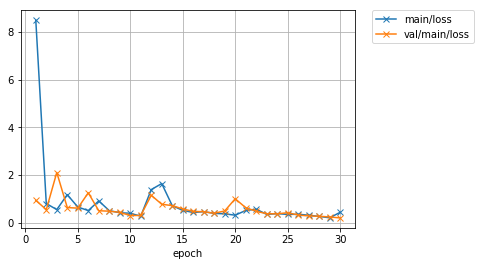

In [14]:
from IPython.display import Image
Image('results/iris_result1/loss.png')

また、正解率のグラフは `acccuracy.png` という名前で保存されています。
こちらも確認してみましょう。

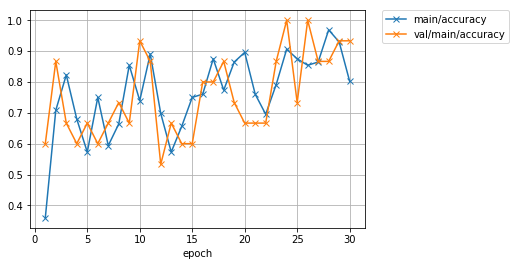

In [15]:
Image('results/iris_result1/accuracy.png')

#### 計算グラフの可視化

`MLP` というネットワークが、どのような構造になっているのかを、視覚的に確認する方法が、`dump_graph` エクステンションによって出力された DOT ファイルを、`pydot` パッケージを使って画像に変換する方法です。
DOT ファイルは、`cg.dot` というファイル名で結果ディレクトリに保存されています。
これを読み込んで、`pydot` を使って画像に変換し、それを表示してみましょう。

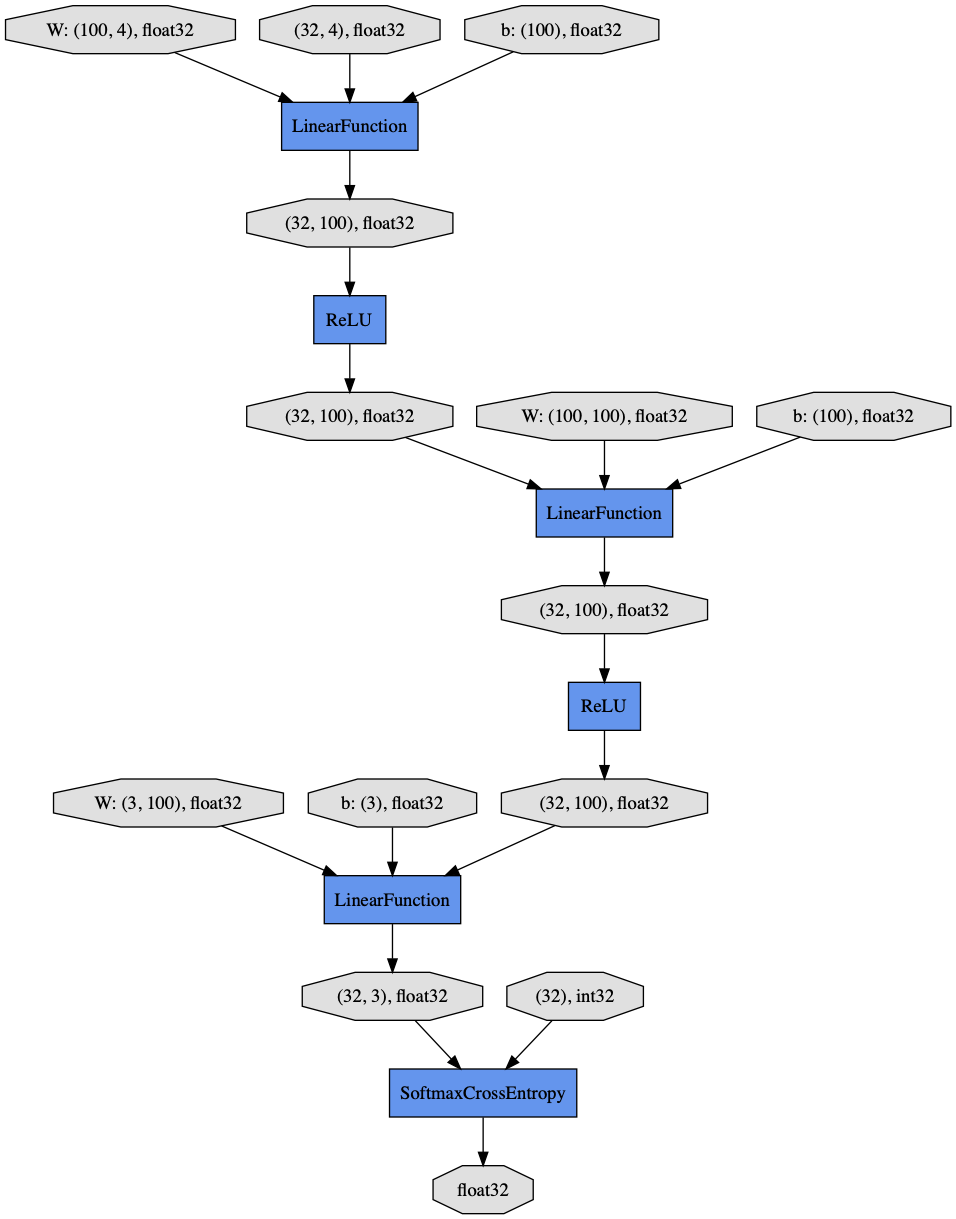

In [16]:
import pydot

file = pydot.graph_from_dot_file('results/iris_result1/cg.dot')
file[0].write_png('graph.png')
Image('graph.png', width=600, height=600)

ここまでで、トレーナの基本的な使い方の解説は終了です。
次節からは、より高度な使い方について説明します。

## レポータで様々な値を記録する


`PrintReport` エクステンションを使うと、現在のエポック、イテレーション、また損失の値や正解率などを標準出力に表示することができました。
これらの値は特にユーザが明示的に指示しなくともデフォルトで `LogReport` が集計できるようにレポートされているため、このようなことが可能になっています。

集計したい値を明示的に指定し、`LogReport` に集計させるようにすることも可能です。
本節では、その方法について説明します。

ネットワークの中で行われる計算の途中結果などを毎イテレーション集計しておき、値の変化を確認したい場合は、**レポータ (reporter)** という機能を用います。

レポータは、`chainer.reporter` モジュールにある `report` 関数を使って、観測対象としたい変数を指定することで、その値を集計することができる機能です。
まずは、レポータの観測対象に `MLP` 内の計算の途中結果を追加してみます。

今回は、ネットワークの定義自体を修正し、`forward` メソッドの中で途中結果を `chainer.reporter.report()` 関数に渡します。

In [17]:
from chainer import reporter


class MLP2(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=3):
        super().__init__()

        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(n_mid_units, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, n_out)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        reporter.report({'avg_y': F.average(h), 'var_y':F.cross_covariance(h, h)}, self)
        h = self.fc3(h)
        return h

この `MLP2` では、2 層目の `fc2` の出力値に ReLU を適用したあとの値について平均と分散を計算し、 `avg_y` と `var_y` という名前でレポータに登録しています。
こうすると、`forward` が呼び出される度にこれらの値がレポートされるようになるため、`LogReport` はその変遷を集計することができます。

このネットワークを訓練して、新しくレポートされる値を `PrintReport` を用いて確認してみましょう。
まずは、新しいネットワークの訓練のための `trainer` オブジェクトを作成します。

In [18]:
# ネットワーク (+ Classifier) 
net = L.Classifier(MLP2())

# オプティマイザ
optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)

# イテレータ
train_iter = iterators.SerialIterator(train, 32)

# アップデータ
updater = training.StandardUpdater(train_iter, optimizer, device=-1) # device=-1でCPUでの計算実行を指定

# トレーナ
trainer = training.Trainer(updater, (30, 'epoch'))

次に、 `LogReport` と `PrintReport` を設定します。
このとき他のエクステンションも `LogReport` が集計した値を用いるため、`LogReport` の追加は必須です。
`PrintReport` には、表示したい値の名前を設定します。

- `epoch`、`iteration`、`elapsed_time`: トレーナオブジェクトがデフォルトでレポートする値で、それぞれエポック数、イテレーション数、経過時間を表します。
- `main` は、オプティマイザが保持するモデル（今回は `L.Classifier`）を表します。
- `main/accuracy` は、`L.Classifier` がデフォルトでレポートする正解率です。
- `main/loss` は、`L.Classifier` がデフォルトでレポートする損失の値です。
- `main/predictor` は、`L.Classifier` に渡されたネットワーク（今回は `MLP2`）を表します。
- `main/predictor/avg_y` は、`net` が保持している ` predictor` の中でレポートされている `avg_y` の値を指します。
- `main/predictor/var_y` は、同様に、`net` が保持している `predictor` の中でレポートされている `var_y` の値を指します。

In [19]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration',
    'main/accuracy',
    'main/predictor/avg_y',
    'main/predictor/var_y',
]))

訓練を開始します。

In [20]:
trainer.run()

epoch       iteration   main/accuracy  main/predictor/avg_y  main/predictor/var_y
1           4           0.421875       0.771195              143.811               
2           7           0.604167       0.127156              10.562                
3           10          0.677083       0.231085              47.6174               
4           14          0.507812       0.257016              288.589               
5           17          0.458333       0.245886              1278.51               
6           20          0.666667       0.146237              167.723               
7           23          0.604167       0.206269              286                   
8           27          0.742188       0.223165              872.823               
9           30          0.677083       0.221028              771.106               
10          33          0.729167       0.151009              855.157               
11          37          0.804688       0.194337              1082.62          

新しくレポートした `avg_y`、`var_y` の集計結果が出力されています。

これらの新しい観測値は、`PlotReport` でグラフを描画する対象に指定すれば、訓練過程での値の変化を描画したグラフを作成させることもできます。

## 訓練の早期終了

**早期終了 (early stopping)** とは、過学習を避けるために行う正則化の一種で、訓練用データセットにフィットしすぎてしまい、途中からテスト用データセットでのエラーが大きくなっていってしまう前に、訓練を途中で打ち切る方法をいいます。

Chainer では `EarlyStoppingTrigger` オブジェクトを作成し、これを訓練終了タイミングを指示するタプルの代わりにトレーナに渡すことで行えます。

`EarlyStoppingTrigger` には、どの指標を用いて早期終了の判断を行うかと、最大の訓練の長さなどを指定します。

以下に使用例を示します。

In [21]:
net = L.Classifier(MLP())

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, False, False)

今回は、早期終了が発生するよう、学習率をわざと大きめに設定します。

In [22]:
optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

早期終了は、`EarlyStoppingTrigger` のインスタンスを `Trainer` のコンストラクタの `stop_trigger` 引数に渡すことで設定します。
`EarlyStoppingTrigger` のコンストラクタに渡す引数で、挙動を定義します。

- `monitor` には、早期終了の判断に使われる指標を指定します。これには、`PrintReport` 等で用いられるのと同じ、レポータによって報告される値を参照する際の形式で指定します。次の `check_trigger` で指定するタイミングで繰り返し行われる値のチェックの際に、これまでの `monitor` の値の平均値が、これまでの最良のものよりも悪化していれば、訓練を停止します。今回は、`Evaluator` によってレポートされる検証用データセットに対する損失をチェック対象に指定します。
- `check_trigger` は、レポートされている変数の値をチェックするタイミングを指定します。今回は、毎エポックチェックを行います。
- `max_trigger` は、トレーナでのループの最大イテレーション数または最大エポック数を指定します。早期終了が行われなかった場合に、ループが永久に続くことを防止します。この例では、最大 30 エポック実行する設定にしています。
- `patients` は、早期終了のしやすさを指定します。たとえば 3 を指定すると、チェック時にそれまでの最良の値を更新できないことが 3 回連続で続いた場合に限って、早期終了するという動作になります。

それでは、`EarlyStoppingTrigger` を作成し、トリガーとトレーナに渡します。

In [23]:
from chainer.training.triggers import EarlyStoppingTrigger

trigger = EarlyStoppingTrigger(monitor='val/main/loss', check_trigger=(1, 'epoch'),
                               patients=5, max_trigger=(30, 'epoch'))
trainer = training.Trainer(updater, trigger, out='results/iris_result5')

早期終了の様子が確認しやすいようにエクステンションを設定します。
また、検証用データセットに対する正解率を `monitor` に使用するため、`Evaluator` を使って検証用データセットに対する正解率を毎エポック計算します。

In [24]:
from chainer.training import extensions

trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=-1), name='val')
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport([
    'epoch', 'main/loss', 'main/accuracy',
    'val/main/loss', 'val/main/accuracy', 'elapsed_time']))

訓練を実行します。

In [25]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           6.90276     0.398438       4.46314        0.333333           0.013383      
2           2.21126     0.458333       0.88056        0.666667           0.204621      
3           0.714306    0.708333       0.855616       0.6                0.392292      
4           0.779072    0.671875       0.461862       0.8                0.600621      
5           0.741514    0.520833       0.563563       0.6                0.782168      
6           0.720288    0.6875         0.670603       0.666667           0.979364      
7           0.628592    0.739583       0.570206       0.6                1.16588       
8           0.536239    0.617188       0.5041         0.6                1.37285       
9           0.446064    0.6875         0.466547       0.666667           1.80874       


In [26]:
!ls results/iris_result5/

accuracy.png log          loss.png


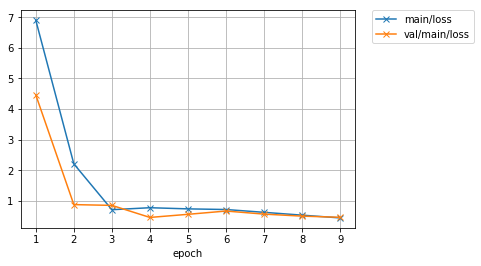

In [27]:
Image('results/iris_result5/loss.png')

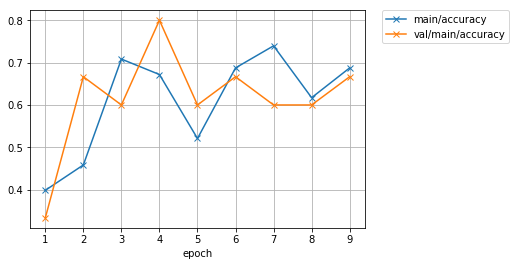

In [28]:
Image('results/iris_result5/accuracy.png')

最大エポック数には 30 を指定していましたが、それよりも早く訓練が終了しました。

早期終了を使用すると、特定の指標での改善が見られなくなった時点で訓練を停止させることができるため、効果の薄い計算が続くことを防ぐことにもなり、計算資源の節約にもなります。

本章では、[前章](https://tutorials.chainer.org/ja/src/15_Advanced_Usage_of_Chainer_ja.html#Step-5-:-ネットワークを訓練する（応用編）)まで行っていたような訓練ループを明示的に書く方法ではなく、トレーナを使って訓練ループを設定し、エクステンションを使って様々な訓練時の情報を集計したり、可視化したり、活用したりする方法を紹介しました。

次章では画像処理の基礎について解説します。

<hr />
<div class="alert alert-info">
**注釈 1**

がく片とは、花弁の付け根にある緑の葉のようなもののことです。

[▲上へ戻る](#ref_note1)
</div>
